### <ins style = 'color : orange'>OFDMA code report, by: KHOUTAIBI Iliass, BARAKA Rayane and LAITA Sami</ins>

In OFDMA systems, resources are allocated in time and frequency.

The proof of all the questions has already been provided in our report, this will be a code implementation of the project

Before starting, let us first import the necessary modules and define the constants to be used throughout the notebook.

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [205]:
# The constants to be used throughout the Notebook
C = 200 
W = 250 
K = 1000 * 1000
gamma = 2.8
R = 300 
lbda = 0.01 
SINRmin = 0.1
p = 0.01
Smin = 30
Smax = 100

Down below we implement the numerous functions and bounds as presented in the project. Specifically, we will be implementing: $N(x)$, the mean of the random variables $\zeta_{k}$ and the maximum number of subcarriers $N_{\text{max}}$.

In [206]:
def N(x):
    """
        Here we get the number of subcarriers needed in a point x
    """
    # Number of subcarriers at point x
    return int(np.ceil(C / (W * np.log2(1 + K/(np.linalg.norm(x) ** gamma)))))

def Nmax():
    """
        Here we get the maximum number of subcarriers
    """
    # Maximum number of subcarriers
    return int(np.ceil(C / (W * np.log2(1 + SINRmin))))

def mean_rv_zeta(k):    
    """
        As stated in the report, the mean of the reandom Variables is the surface of the ring of radius R_{k+1}^2 - R{k}^2
    """

    # Upper and Lower bounds of the ring
    upper_bound = K / (2**(C/(k * W)) - 1)
    lower_bound = K / (2**(C/((k-1) * W)) - 1) if k > 1 else 0

    result =  p * lbda * np.pi * np.abs(upper_bound**(2/gamma) - lower_bound**(2/gamma))
    
    return result

Now we will try to simulate the processes of subcarriers, by drawing unifrmally in a Disk of Radius R, and another Bernouilli Random Variable which determins if the user is active of not.

In [207]:
def generate_points_circle(nmax):

    """
    
        Function which generates the random variables from the disk of Radius R
        The function also only samples the active users, which are chosen using the param p

    """
    
    # Sample a radius from uniform distribution and angles too
    r = np.random.uniform(0, 1, size=(nmax, 1)) * R
    theta = np.random.uniform(0, 2 * np.pi, size=(nmax, 1))
    
    x = r * np.cos(theta) 
    y = r * np.sin(theta) 

    # Choose whether to keep the user or not based on p
    keep = np.random.rand(nmax) < p

    # Stacking the coordinates 
    result = np.hstack((x, y))[keep]

    return result

def draw_disk():

    """
        Function which plots a circle
    """

    theta = np.linspace(0, 2 * np.pi, 100)
    plt.plot(R * np.cos(theta), R * np.sin(theta), color = 'red')
    plt.grid()    

Now, let us simulate $100 000$ users and their needed subcarriers

In [208]:
Users = generate_points_circle(100_000)

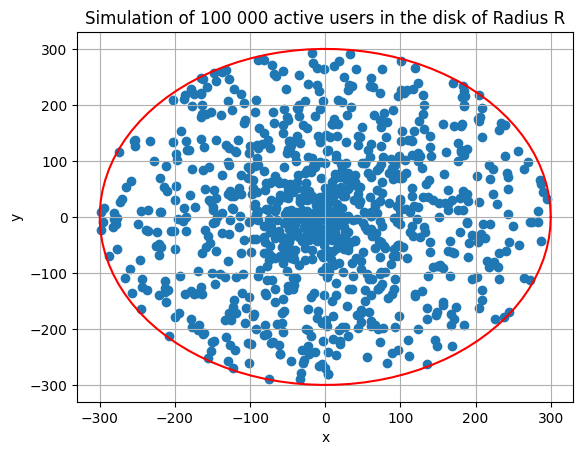

In [209]:
plt.scatter(Users[:, 0], Users[:, 1])
plt.title("Simulation of 100 000 active users in the disk of Radius R")
draw_disk()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now, let us keep the users that only need 3 subcarriers, i.e in the case where $N(x) = 3$.

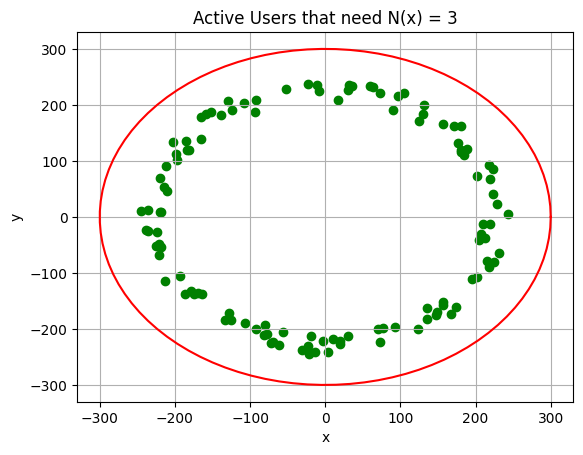

In [210]:
N_3 = [] # List of users needing 3 subcarriers

# Keeping only the ones that need 3 subcarriers, i.e N(x) == 3
for i in range(Users.shape[0]):
    number_points = N(Users[i])
    if number_points == 3:
        N_3.append(Users[i])

# Transforming to numpy array
N_3 = np.array(N_3)

# Plotting the results
plt.scatter(N_3[:, 0], N_3[:, 1], color='green')
draw_disk()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Active Users that need N(x) = 3")
plt.show()

To empirically corroborate the theoretical results found in the report, we can proceed with the **Kolmogorov–Smirnov (K–S) test**, which performs the following:

- Given a sample ${X_1, X_2, \\dots, X_n}$, the K–S test compares the **empirical cumulative distribution function (ECDF)**, denoted by $\hat{F}_n(x)$, with a theoretical cumulative distribution function $F(x)$ (e.g., the CDF of the Poisson distribution in our case).

- The K–S test statistic is defined as:
  $$
  D_n = \sup_x \left| \hat{F}_n(x) - F(x) \right|
  $$

- The null hypothesis $H_0$ is that the sample comes from the distribution $F$. The test computes the probability (p-value) that a statistic as extreme as $D_n$ would occur under $H_0$.

- If the p-value is **large** (e.g., $> 0.05$), we **do not reject** the hypothesis that the sample follows the theoretical distribution. If the p-value is **small**, we reject it.

Fortunately, scipy already implements the K-S test function, which we will be using down below.

Empirical mean: 5.31
Theoretical mean: 5.241304921074716
The p-value is: 0.0003336137212388148


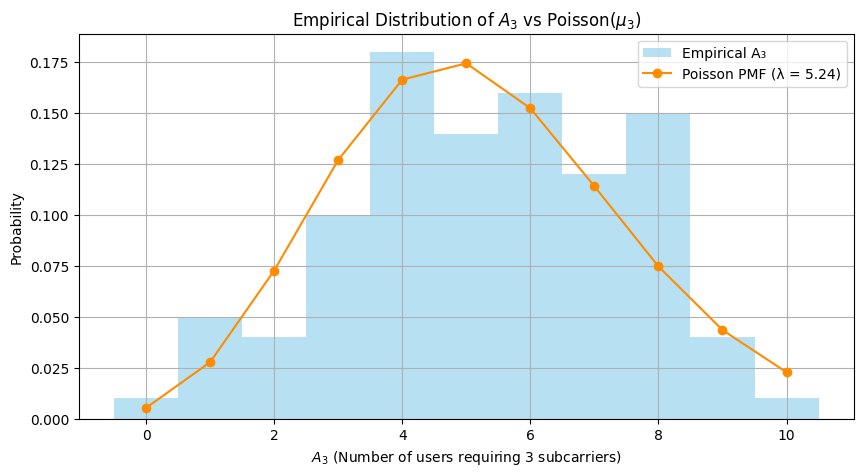

In [211]:
# Test random variables
test_rvs = []
num_samples = 100

# Sampling
for _ in range(num_samples):   
    temp = generate_points_circle(4500)
    filtered = [N(p) for p in temp]
    A3 = np.sum([1 for n in filtered if n == 3])
    test_rvs.append(A3)

# Calculate sample statistics
mean_test = np.mean(test_rvs)
std_test = np.std(test_rvs)
lambda_theory = mean_rv_zeta(3)

print(f"Empirical mean: {mean_test}")
print(f"Theoretical mean: {lambda_theory}")

# Kolmogorov-Smirnov test
D, pvalue = sp.stats.kstest(test_rvs, sp.stats.poisson(lambda_theory).cdf)
print(f"The p-value is: {pvalue}")

# Plotting
x_vals = np.arange(min(test_rvs), max(test_rvs)+1)
poisson_pmf = sp.stats.poisson(mu=lambda_theory).pmf(x_vals)

plt.figure(figsize=(10, 5))

plt.hist(test_rvs, bins=np.arange(min(test_rvs)-0.5, max(test_rvs)+1.5), 
         density=True, alpha=0.6, color='skyblue', label='Empirical A₃')
plt.plot(x_vals, poisson_pmf, 'o-', color='darkorange', label='Poisson PMF (λ = {:.2f})'.format(lambda_theory))

plt.title(r'Empirical Distribution of $A_3$ vs Poisson($\mu_{3}$)')
plt.xlabel('$A_3$ (Number of users requiring 3 subcarriers)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.show()

We can see a low p-value, but a distribution that closely matches the Poisson distribution of mean: $\mu_{3}$. This is most likely due to how the test is performed for discrete random variables.

In order to solve this, it is possible to use the $\text{Ki-2}$ test.

Let us now move onto answering Question 9 of the project.

- Comupting $N_{\text{max}}$

In [212]:
# Computing N_max
N_max = Nmax()
print(f"The maximum number of subcarriers is: {N_max}")

The maximum number of subcarriers is: 6


- compute the size of the vector which represents the distribution of $\zeta_{k} \forall k = 1, · · · , N_{\text{max}}$ and take $K$ to be the supremum of these dimensions.

First we compute the means of the random variables, a simple plot too in order to see their values.

The mean of the Zetas from 1 to 6 is: [7.51292097 6.18976995 5.24130492 4.71923505 4.37078461 4.11434742]


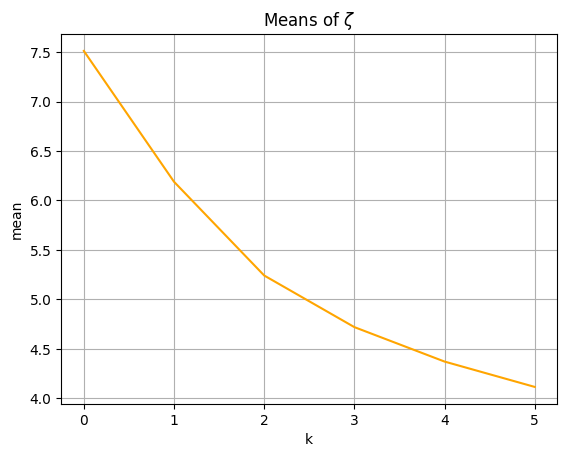

In [213]:
# Computing the means and the mean of the zetas
means_zetas = np.zeros(N_max)

for i in range(1, N_max  + 1):
    mean = mean_rv_zeta(i)
    means_zetas[i - 1] = mean

print(f"The mean of the Zetas from 1 to 6 is: {means_zetas}")

plt.plot(means_zetas, color = 'orange')
plt.title(r"Means of $\zeta$")
plt.xlabel('k')
plt.ylabel('mean')
plt.grid()
plt.show()

Now we can estimate $K$, the supremum of these dimensions.

In [214]:
# Define the function to be minimized
def f(x, nu):
    return x*(1 - np.log(x)) - 1 + 4 * np.log(10) / nu


# Solving the problem
K_s = np.zeros(N_max)

for i in range(1, N_max + 1):
    nu = mean_rv_zeta(i)
    K_optim = sp.optimize.fsolve(f, K, args=(nu))
    K_s[i - 1] = K_optim[0] * nu

K_s = np.ceil(K_s)
Kmax = np.max(K_s).astype(int)
# Here we get the Ks necessary to represent a random variable following poisson of parameter nu
print(f"The Ks found are: {K_s}, while the maximum K is: {Kmax}")

The Ks found are: [23. 20. 18. 17. 17. 16.], while the maximum K is: 23


- Construct the vectors representing the distribution of the $\zeta_{k}$.

In [215]:
# Init the distribution for zeta
distribution_zeta = np.zeros(shape=(N_max, Kmax))

# Computing the distribution
for i in range(1, N_max + 1):
    nu = mean_rv_zeta(i)
    for j in range(Kmax):
        distribution_zeta[i - 1, j] = np.exp(-nu) * (nu ** j) / sp.special.factorial(j)


Let us plot and see the distribution of our random varibale $\zeta_{2}$.

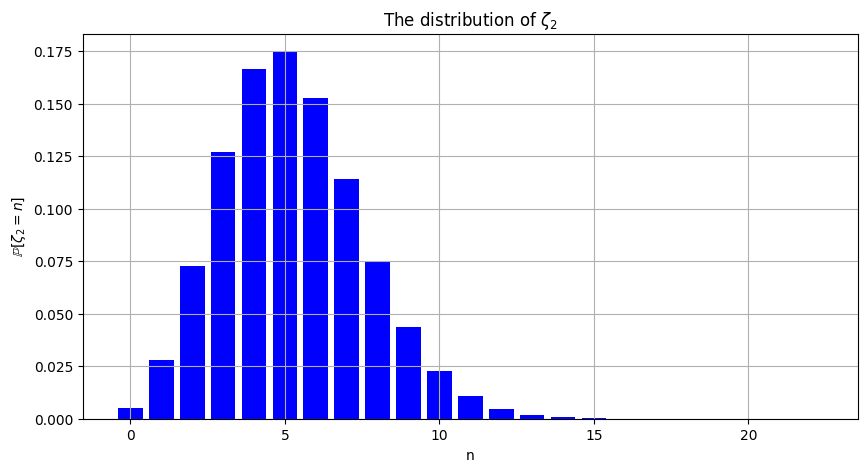

In [216]:
# Plotting the results
x = np.arange(0, Kmax, 1)
plt.figure(figsize=(10, 5))
plt.bar(x, distribution_zeta[2], color = 'blue')
plt.xlabel('n')
plt.ylabel(r'$\mathbb{P}[\zeta_{2} = n]$')
plt.title(r"The distribution of $\zeta_{2}$")
plt.grid()

- Construct the vectors representing the distribution of the $k \zeta_{k}$.

In [217]:
# Init the matrix of zeros
distribution_k_zeta = np.zeros((N_max, Kmax * N_max))

# computing the random variables
for i in range(1, N_max + 1):
    nu = mean_rv_zeta(i)
    for j in range(Kmax):
        distribution_k_zeta[i - 1, i * j] =  np.exp(-nu) * (nu ** j) / sp.special.factorial(j)

Let us plot and see the distribution of our random varibale $2\zeta_{2}$.

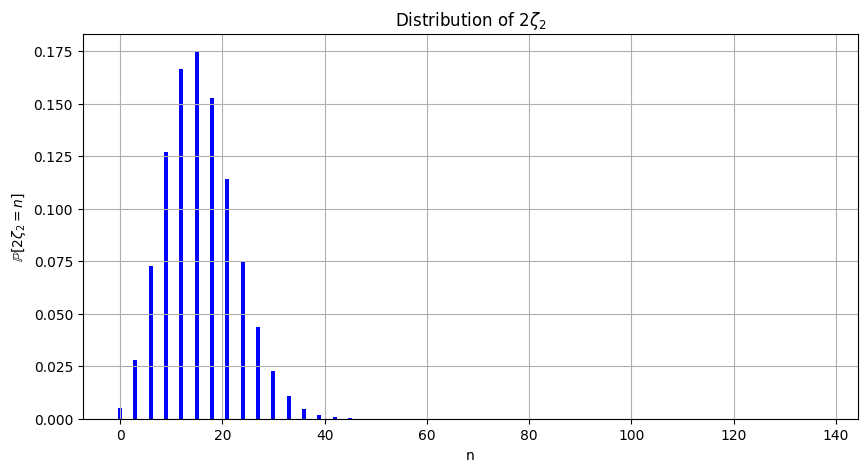

In [218]:
x = np.arange(0, Kmax * N_max, 1)
plt.figure(figsize=(10, 5))
plt.bar(x, distribution_k_zeta[2], color = 'blue')
plt.xlabel('n')
plt.ylabel(r'$\mathbb{P}[2\zeta_{2} = n]$')
plt.title(r"Distribution of $2\zeta_{2}$")
plt.grid()

- Using the numpy.convolve, build the vector representing the distribution of $F$.

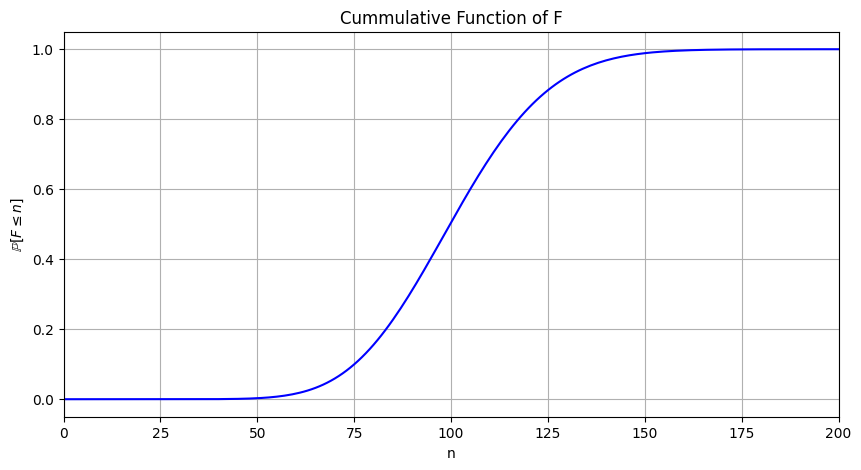

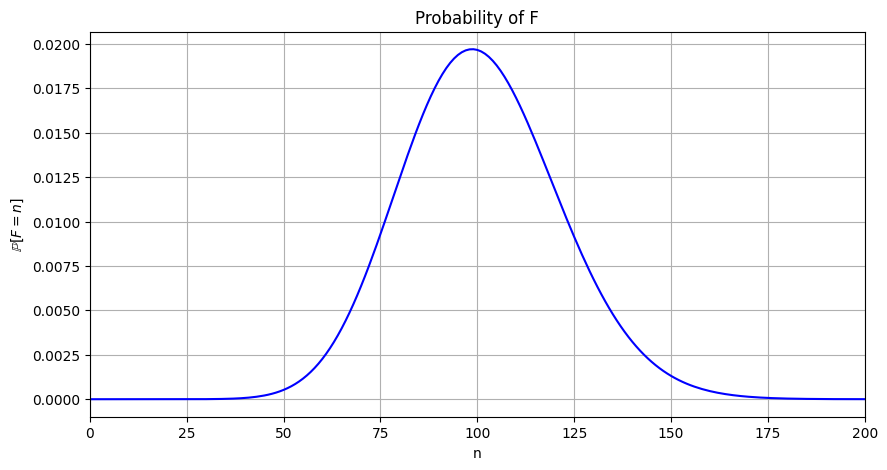

In [219]:
# Inint F
F = distribution_k_zeta[0]

# Convolving with each zeta
for i in range(1, N_max):
    F = np.convolve(F, distribution_k_zeta[i])

# Plotting the results
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(np.cumsum(F), color = 'blue')
plt.title("Cummulative Function of F")
plt.xlabel('n')
plt.ylabel(r'$\mathbb{P}[F \leq n]$')
plt.xlim(0, 200)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(F, color = 'blue')
plt.xlim((0, 200))
plt.title("Probability of F")
plt.xlabel('n')
plt.ylabel(r'$\mathbb{P}[F = n]$')
plt.grid()
plt.show()

- Compute S such that the outage probability is smaller than $0.01$.

In order to compute S, we can sum the number of points whose probability is less than $0.99$, which can easily be done with numpy.

In [220]:
# Cummulative Function
cummulative_F = np.cumsum(F)
S = cummulative_F[cummulative_F < 0.99]
outage_probability = len(S)
print(f'S for an outage probability less than 0.01 is: {outage_probability}')

S for an outage probability less than 0.01 is: 152
